In [1]:
import torch
import numpy as np
from torch import nn
import time
import torch.nn.functional as F
import matplotlib.pyplot as plt
import dlc_practical_prologue as prologue

In [2]:
#Sometimes download directly will have http403 error
from six.moves import urllib
# have to add a header to your urllib request (due to that site moving to Cloudflare protection)
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)
#*********************** 

In [3]:
N_PAIRS = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N_PAIRS)

In [4]:
print(train_input.shape)
print(train_classes.shape)
print(train_target.shape)
print(test_input.shape)
print(test_classes.shape)
print(test_target.shape)

torch.Size([1000, 2, 14, 14])
torch.Size([1000, 2])
torch.Size([1000])
torch.Size([1000, 2, 14, 14])
torch.Size([1000, 2])
torch.Size([1000])


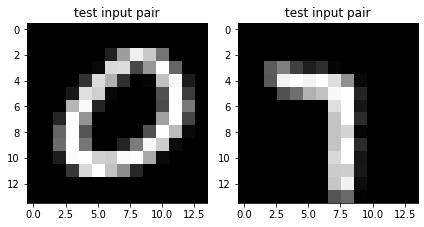

The test classes are: 0 and 7.
The test target is: 0


In [5]:
# discribe the data
fig = plt.figure()
for i in range(2):
  plt.subplot(1,2,i+1)
  plt.imshow(test_input[0][i], cmap='gray')
  plt.title("test input pair")  
  plt.tight_layout()
plt.show()
print("The test classes are: %d and %d."%(test_classes[0][0].item(),test_classes[0][1].item()))
print("The test target is: %d"%(train_target[0]))

In [6]:
# combine two images into one 1*392 tensor
# prepare for entering the MLP net.
print(train_input.shape)
tran_train_input=train_input.view(-1,2*14*14)
print(tran_train_input.shape)

torch.Size([1000, 2, 14, 14])
torch.Size([1000, 392])


In [7]:
# Do the same for the test data set in the same way
tran_test_input=test_input.view(-1,2*14*14)
print(tran_test_input.shape)

torch.Size([1000, 392])


In [8]:
class MLP_Net(nn.Module):
#     initialize the model
    def __init__(self):
        super(MLP_Net, self).__init__()
        self.linear1 = nn.Linear(2*14*14, 200)
        self.linear2 = nn.Linear(200, 50)
#         self.linear3 = nn.Linear (200, 50)
#         self.linear4 = nn.Linear (100, 50)
        self.linear5 = nn.Linear (50, 20)
        self.linear_out = nn.Linear(20,2)
        # training parameter
        self.batch_size = 50
        self.criterion = nn.CrossEntropyLoss()
        self.num_epochs = 25
        self.optimizer = torch.optim.Adam(self.parameters(), lr=2e-3)

    def forward(self, x):
        x = F.relu(self.linear1(x.view(-1,2*14*14)))
        x = F.relu(self.linear2(x))
#         x = F.relu(self.linear3(x))
#         x = F.relu(self.linear4(x))
        x = F.relu(self.linear5(x))
        x = self.linear_out(x)       
        return x
     # Training Function

    def trainer(self, train_input, train_target, test_input, test_target):
        """
        Train the model on a training set
        :param train_input: Training features
        :param train_target: Training labels
        """
        start_time = time.time()
        train_loss_history=[]
        test_loss_history=[]
        train_accuracy=[]
        test_accuracy=[]
        for epoch in range(self.num_epochs):
            # train mode
            self.train()
            for batch_idx in range(0,train_input.size(0),self.batch_size):
                output = self(train_input[batch_idx:batch_idx+self.batch_size]) 
                loss = self.criterion(output, train_target[batch_idx:batch_idx+self.batch_size])  
                self.optimizer.zero_grad()#set gradients to zero
                loss.backward() #backpropagation
                self.optimizer.step()
                # print the loss in every 50 epoch
                if not batch_idx % 50:
                    print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.6f' 
                           %(epoch+1, self.num_epochs, batch_idx, 
                             len(train_input), loss))
            # test mode
            self.eval()
            # get the training loss and accuracy
            train_predicted = self(train_input)
            train_loss = self.criterion(train_predicted, train_target)
            train_loss_history.append(train_loss)
            _, train_pred = torch.max(train_predicted, 1)   #return the index of the bigger result
            train_accuracy_result=self.compute_accuracy(train_target,train_pred)
            train_accuracy.append(train_accuracy_result)

            # get the testing loss and accuracy
            test_predicted = self(test_input)
            test_loss = self.criterion(test_predicted, test_target)
            test_loss_history.append(test_loss)
            _, test_pred = torch.max(test_predicted, 1)   #return the index of the bigger result
            test_accuracy_result=self.compute_accuracy(test_target,test_pred)
            test_accuracy.append(test_accuracy_result)
            
#       print the time used in one epoch
            print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
#       print the total training time used 
        print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
        
        #Setting-up the plot
        plt.figure(figsize=(15,8))

        ax1 = plt.subplot(1,2,1)

        ax2 = plt.subplot(1,2,2)

        #Drawing and labeling the curves
        ax1.plot(train_loss_history, label="Training Loss")
        ax1.plot(test_loss_history, label="Test Loss")

        #Adding the title and axis labels
        ax1.set_title('Train VS Test Loss')
        ax1.set_ylabel('Loss')
        ax1.set_xlabel('Epoch')
        ax1.legend()

    #     #Saving the plot
    #     ax1.figure.savefig(model.model_name+'loss.png')


        #Drawing and labeling the curves
        ax2.plot(train_accuracy, label="Train Accuracy")
        ax2.plot(test_accuracy, label="Test Accuracy")

        #Adding the title and axis labels
        ax2.set_title('Train VS Test Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.legend()

         # Test error

    def compute_error(self, input_data, target):
        """
        Compute the number of error of the model on a test set
        :param input_data: test features
        :param target: test target
        :return: error rate of the input data
        """  
    
        #test mode
        self.eval()
        outputs= self(input_data)
        _, predicted = torch.max(outputs, 1)
        return 1-self.compute_accuracy(target,predicted)
        
    
    def compute_accuracy(self, target, pred):
        """
        Compute the training and testing error
        :param target: target data (whether 1 or 0)
        :param pred: predicted data
        :return 
        """
        return (target-pred).eq(0).float().mean().item()
    
    def save_model(self,model_name):
        """
        Save the model to this folder
        :param model_name: the model name, e.g. CNN_Net.pth
        """         
        torch.save(self, './model/'+model_name)

In [9]:
# build an net instance
my_model = MLP_Net()
# save the model
my_model.save_model('MLP_Net.pth')

Epoch: 001/025 | Batch 000/1000 | Loss: 1.827769
Epoch: 001/025 | Batch 050/1000 | Loss: 2.910946
Epoch: 001/025 | Batch 100/1000 | Loss: 0.926376
Epoch: 001/025 | Batch 150/1000 | Loss: 0.923795
Epoch: 001/025 | Batch 200/1000 | Loss: 0.798040
Epoch: 001/025 | Batch 250/1000 | Loss: 1.227000
Epoch: 001/025 | Batch 300/1000 | Loss: 0.637290
Epoch: 001/025 | Batch 350/1000 | Loss: 0.667704
Epoch: 001/025 | Batch 400/1000 | Loss: 0.613577
Epoch: 001/025 | Batch 450/1000 | Loss: 0.557641
Epoch: 001/025 | Batch 500/1000 | Loss: 0.531455
Epoch: 001/025 | Batch 550/1000 | Loss: 0.597950
Epoch: 001/025 | Batch 600/1000 | Loss: 0.554580
Epoch: 001/025 | Batch 650/1000 | Loss: 0.568434
Epoch: 001/025 | Batch 700/1000 | Loss: 0.642485
Epoch: 001/025 | Batch 750/1000 | Loss: 0.526983
Epoch: 001/025 | Batch 800/1000 | Loss: 0.468473
Epoch: 001/025 | Batch 850/1000 | Loss: 0.578285
Epoch: 001/025 | Batch 900/1000 | Loss: 0.497714
Epoch: 001/025 | Batch 950/1000 | Loss: 0.448275
Time elapsed: 0.00 m

Epoch: 009/025 | Batch 800/1000 | Loss: 0.094852
Epoch: 009/025 | Batch 850/1000 | Loss: 0.282349
Epoch: 009/025 | Batch 900/1000 | Loss: 0.062439
Epoch: 009/025 | Batch 950/1000 | Loss: 0.142234
Time elapsed: 0.01 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.169790
Epoch: 010/025 | Batch 050/1000 | Loss: 0.104170
Epoch: 010/025 | Batch 100/1000 | Loss: 0.065822
Epoch: 010/025 | Batch 150/1000 | Loss: 0.067478
Epoch: 010/025 | Batch 200/1000 | Loss: 0.033473
Epoch: 010/025 | Batch 250/1000 | Loss: 0.154831
Epoch: 010/025 | Batch 300/1000 | Loss: 0.231734
Epoch: 010/025 | Batch 350/1000 | Loss: 0.038063
Epoch: 010/025 | Batch 400/1000 | Loss: 0.051078
Epoch: 010/025 | Batch 450/1000 | Loss: 0.042860
Epoch: 010/025 | Batch 500/1000 | Loss: 0.050847
Epoch: 010/025 | Batch 550/1000 | Loss: 0.090006
Epoch: 010/025 | Batch 600/1000 | Loss: 0.033304
Epoch: 010/025 | Batch 650/1000 | Loss: 0.035590
Epoch: 010/025 | Batch 700/1000 | Loss: 0.095113
Epoch: 010/025 | Batch 750/1000 | Loss: 0.0850

Epoch: 019/025 | Batch 200/1000 | Loss: 0.001583
Epoch: 019/025 | Batch 250/1000 | Loss: 0.007309
Epoch: 019/025 | Batch 300/1000 | Loss: 0.006361
Epoch: 019/025 | Batch 350/1000 | Loss: 0.003021
Epoch: 019/025 | Batch 400/1000 | Loss: 0.001799
Epoch: 019/025 | Batch 450/1000 | Loss: 0.005179
Epoch: 019/025 | Batch 500/1000 | Loss: 0.002453
Epoch: 019/025 | Batch 550/1000 | Loss: 0.001329
Epoch: 019/025 | Batch 600/1000 | Loss: 0.000867
Epoch: 019/025 | Batch 650/1000 | Loss: 0.001628
Epoch: 019/025 | Batch 700/1000 | Loss: 0.000965
Epoch: 019/025 | Batch 750/1000 | Loss: 0.001602
Epoch: 019/025 | Batch 800/1000 | Loss: 0.001594
Epoch: 019/025 | Batch 850/1000 | Loss: 0.001229
Epoch: 019/025 | Batch 900/1000 | Loss: 0.001309
Epoch: 019/025 | Batch 950/1000 | Loss: 0.004730
Time elapsed: 0.01 min
Epoch: 020/025 | Batch 000/1000 | Loss: 0.003390
Epoch: 020/025 | Batch 050/1000 | Loss: 0.002097
Epoch: 020/025 | Batch 100/1000 | Loss: 0.000908
Epoch: 020/025 | Batch 150/1000 | Loss: 0.0009

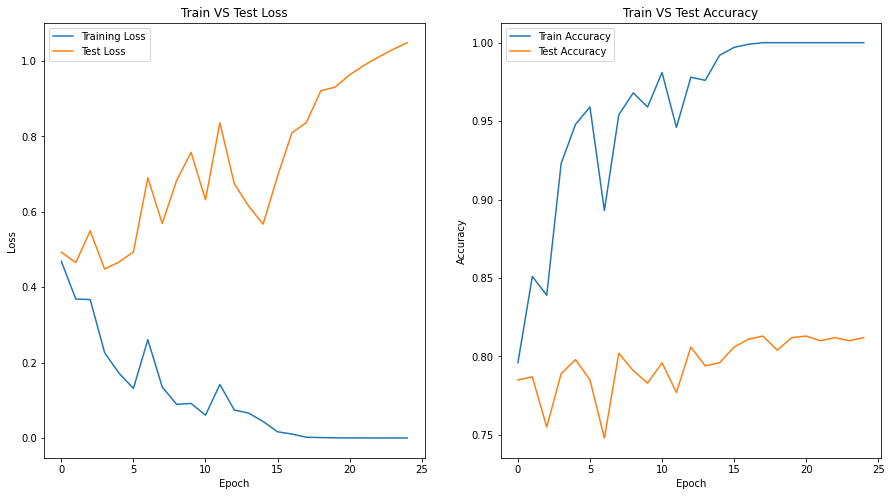

In [10]:
# train the model and get the training and testing plot
my_model.trainer(tran_train_input, train_target,tran_test_input, test_target)

In [11]:
# output the train error and test error

print("The total number of the parameters is: %d" % (sum(p.numel() for p in my_model.parameters())))

The total number of the parameters is: 89712


Epoch: 001/025 | Batch 000/1000 | Loss: 1.217034
Epoch: 001/025 | Batch 050/1000 | Loss: 3.159672
Epoch: 001/025 | Batch 100/1000 | Loss: 1.068681
Epoch: 001/025 | Batch 150/1000 | Loss: 0.949529
Epoch: 001/025 | Batch 200/1000 | Loss: 0.695921
Epoch: 001/025 | Batch 250/1000 | Loss: 1.227206
Epoch: 001/025 | Batch 300/1000 | Loss: 0.763331
Epoch: 001/025 | Batch 350/1000 | Loss: 0.590280
Epoch: 001/025 | Batch 400/1000 | Loss: 0.809360
Epoch: 001/025 | Batch 450/1000 | Loss: 0.659114
Epoch: 001/025 | Batch 500/1000 | Loss: 0.557595
Epoch: 001/025 | Batch 550/1000 | Loss: 0.663264
Epoch: 001/025 | Batch 600/1000 | Loss: 0.605650
Epoch: 001/025 | Batch 650/1000 | Loss: 0.609617
Epoch: 001/025 | Batch 700/1000 | Loss: 0.544549
Epoch: 001/025 | Batch 750/1000 | Loss: 0.587210
Epoch: 001/025 | Batch 800/1000 | Loss: 0.552001
Epoch: 001/025 | Batch 850/1000 | Loss: 0.504652
Epoch: 001/025 | Batch 900/1000 | Loss: 0.738409
Epoch: 001/025 | Batch 950/1000 | Loss: 0.419568
Time elapsed: 0.00 m

Epoch: 010/025 | Batch 700/1000 | Loss: 0.143588
Epoch: 010/025 | Batch 750/1000 | Loss: 0.238702
Epoch: 010/025 | Batch 800/1000 | Loss: 0.263688
Epoch: 010/025 | Batch 850/1000 | Loss: 0.077874
Epoch: 010/025 | Batch 900/1000 | Loss: 0.099648
Epoch: 010/025 | Batch 950/1000 | Loss: 0.115618
Time elapsed: 0.01 min
Epoch: 011/025 | Batch 000/1000 | Loss: 0.155194
Epoch: 011/025 | Batch 050/1000 | Loss: 0.090967
Epoch: 011/025 | Batch 100/1000 | Loss: 0.060198
Epoch: 011/025 | Batch 150/1000 | Loss: 0.053957
Epoch: 011/025 | Batch 200/1000 | Loss: 0.125605
Epoch: 011/025 | Batch 250/1000 | Loss: 0.134132
Epoch: 011/025 | Batch 300/1000 | Loss: 0.054467
Epoch: 011/025 | Batch 350/1000 | Loss: 0.031276
Epoch: 011/025 | Batch 400/1000 | Loss: 0.077060
Epoch: 011/025 | Batch 450/1000 | Loss: 0.109237
Epoch: 011/025 | Batch 500/1000 | Loss: 0.023203
Epoch: 011/025 | Batch 550/1000 | Loss: 0.051561
Epoch: 011/025 | Batch 600/1000 | Loss: 0.033867
Epoch: 011/025 | Batch 650/1000 | Loss: 0.0428

Epoch: 020/025 | Batch 750/1000 | Loss: 0.000093
Epoch: 020/025 | Batch 800/1000 | Loss: 0.000081
Epoch: 020/025 | Batch 850/1000 | Loss: 0.000098
Epoch: 020/025 | Batch 900/1000 | Loss: 0.000119
Epoch: 020/025 | Batch 950/1000 | Loss: 0.000014
Time elapsed: 0.01 min
Epoch: 021/025 | Batch 000/1000 | Loss: 0.000454
Epoch: 021/025 | Batch 050/1000 | Loss: 0.000079
Epoch: 021/025 | Batch 100/1000 | Loss: 0.000066
Epoch: 021/025 | Batch 150/1000 | Loss: 0.000042
Epoch: 021/025 | Batch 200/1000 | Loss: 0.000148
Epoch: 021/025 | Batch 250/1000 | Loss: 0.000137
Epoch: 021/025 | Batch 300/1000 | Loss: 0.000219
Epoch: 021/025 | Batch 350/1000 | Loss: 0.000066
Epoch: 021/025 | Batch 400/1000 | Loss: 0.000136
Epoch: 021/025 | Batch 450/1000 | Loss: 0.000163
Epoch: 021/025 | Batch 500/1000 | Loss: 0.000091
Epoch: 021/025 | Batch 550/1000 | Loss: 0.000176
Epoch: 021/025 | Batch 600/1000 | Loss: 0.000095
Epoch: 021/025 | Batch 650/1000 | Loss: 0.000096
Epoch: 021/025 | Batch 700/1000 | Loss: 0.0002

Epoch: 007/025 | Batch 000/1000 | Loss: 0.174504
Epoch: 007/025 | Batch 050/1000 | Loss: 0.182788
Epoch: 007/025 | Batch 100/1000 | Loss: 0.459843
Epoch: 007/025 | Batch 150/1000 | Loss: 0.479929
Epoch: 007/025 | Batch 200/1000 | Loss: 0.339743
Epoch: 007/025 | Batch 250/1000 | Loss: 0.390403
Epoch: 007/025 | Batch 300/1000 | Loss: 0.584687
Epoch: 007/025 | Batch 350/1000 | Loss: 0.201472
Epoch: 007/025 | Batch 400/1000 | Loss: 0.326668
Epoch: 007/025 | Batch 450/1000 | Loss: 0.213190
Epoch: 007/025 | Batch 500/1000 | Loss: 0.394937
Epoch: 007/025 | Batch 550/1000 | Loss: 0.283861
Epoch: 007/025 | Batch 600/1000 | Loss: 0.265760
Epoch: 007/025 | Batch 650/1000 | Loss: 0.277229
Epoch: 007/025 | Batch 700/1000 | Loss: 0.155512
Epoch: 007/025 | Batch 750/1000 | Loss: 0.225998
Epoch: 007/025 | Batch 800/1000 | Loss: 0.190226
Epoch: 007/025 | Batch 850/1000 | Loss: 0.275771
Epoch: 007/025 | Batch 900/1000 | Loss: 0.341031
Epoch: 007/025 | Batch 950/1000 | Loss: 0.229452
Time elapsed: 0.00 m

Epoch: 018/025 | Batch 950/1000 | Loss: 0.024548
Time elapsed: 0.01 min
Epoch: 019/025 | Batch 000/1000 | Loss: 0.015338
Epoch: 019/025 | Batch 050/1000 | Loss: 0.021783
Epoch: 019/025 | Batch 100/1000 | Loss: 0.009350
Epoch: 019/025 | Batch 150/1000 | Loss: 0.006425
Epoch: 019/025 | Batch 200/1000 | Loss: 0.034278
Epoch: 019/025 | Batch 250/1000 | Loss: 0.215694
Epoch: 019/025 | Batch 300/1000 | Loss: 0.081896
Epoch: 019/025 | Batch 350/1000 | Loss: 0.010842
Epoch: 019/025 | Batch 400/1000 | Loss: 0.071651
Epoch: 019/025 | Batch 450/1000 | Loss: 0.010250
Epoch: 019/025 | Batch 500/1000 | Loss: 0.021220
Epoch: 019/025 | Batch 550/1000 | Loss: 0.058727
Epoch: 019/025 | Batch 600/1000 | Loss: 0.015173
Epoch: 019/025 | Batch 650/1000 | Loss: 0.040169
Epoch: 019/025 | Batch 700/1000 | Loss: 0.089077
Epoch: 019/025 | Batch 750/1000 | Loss: 0.023794
Epoch: 019/025 | Batch 800/1000 | Loss: 0.013609
Epoch: 019/025 | Batch 850/1000 | Loss: 0.116609
Epoch: 019/025 | Batch 900/1000 | Loss: 0.1640

Epoch: 004/025 | Batch 650/1000 | Loss: 0.351149
Epoch: 004/025 | Batch 700/1000 | Loss: 0.373742
Epoch: 004/025 | Batch 750/1000 | Loss: 0.165503
Epoch: 004/025 | Batch 800/1000 | Loss: 0.180294
Epoch: 004/025 | Batch 850/1000 | Loss: 0.322945
Epoch: 004/025 | Batch 900/1000 | Loss: 0.393757
Epoch: 004/025 | Batch 950/1000 | Loss: 0.234956
Time elapsed: 0.00 min
Epoch: 005/025 | Batch 000/1000 | Loss: 0.302623
Epoch: 005/025 | Batch 050/1000 | Loss: 0.388974
Epoch: 005/025 | Batch 100/1000 | Loss: 0.253498
Epoch: 005/025 | Batch 150/1000 | Loss: 0.213185
Epoch: 005/025 | Batch 200/1000 | Loss: 0.255193
Epoch: 005/025 | Batch 250/1000 | Loss: 0.209802
Epoch: 005/025 | Batch 300/1000 | Loss: 0.354489
Epoch: 005/025 | Batch 350/1000 | Loss: 0.416012
Epoch: 005/025 | Batch 400/1000 | Loss: 0.280143
Epoch: 005/025 | Batch 450/1000 | Loss: 0.302775
Epoch: 005/025 | Batch 500/1000 | Loss: 0.274126
Epoch: 005/025 | Batch 550/1000 | Loss: 0.249865
Epoch: 005/025 | Batch 600/1000 | Loss: 0.3049

Epoch: 014/025 | Batch 800/1000 | Loss: 0.117546
Epoch: 014/025 | Batch 850/1000 | Loss: 0.052920
Epoch: 014/025 | Batch 900/1000 | Loss: 0.028047
Epoch: 014/025 | Batch 950/1000 | Loss: 0.199289
Time elapsed: 0.01 min
Epoch: 015/025 | Batch 000/1000 | Loss: 0.044612
Epoch: 015/025 | Batch 050/1000 | Loss: 0.073087
Epoch: 015/025 | Batch 100/1000 | Loss: 0.107363
Epoch: 015/025 | Batch 150/1000 | Loss: 0.012072
Epoch: 015/025 | Batch 200/1000 | Loss: 0.069638
Epoch: 015/025 | Batch 250/1000 | Loss: 0.138437
Epoch: 015/025 | Batch 300/1000 | Loss: 0.182313
Epoch: 015/025 | Batch 350/1000 | Loss: 0.423496
Epoch: 015/025 | Batch 400/1000 | Loss: 0.028679
Epoch: 015/025 | Batch 450/1000 | Loss: 0.357060
Epoch: 015/025 | Batch 500/1000 | Loss: 0.240450
Epoch: 015/025 | Batch 550/1000 | Loss: 0.388275
Epoch: 015/025 | Batch 600/1000 | Loss: 0.114880
Epoch: 015/025 | Batch 650/1000 | Loss: 0.076812
Epoch: 015/025 | Batch 700/1000 | Loss: 0.052034
Epoch: 015/025 | Batch 750/1000 | Loss: 0.4478

Epoch: 025/025 | Batch 400/1000 | Loss: 0.000498
Epoch: 025/025 | Batch 450/1000 | Loss: 0.001137
Epoch: 025/025 | Batch 500/1000 | Loss: 0.007931
Epoch: 025/025 | Batch 550/1000 | Loss: 0.063400
Epoch: 025/025 | Batch 600/1000 | Loss: 0.012574
Epoch: 025/025 | Batch 650/1000 | Loss: 0.123542
Epoch: 025/025 | Batch 700/1000 | Loss: 0.039224
Epoch: 025/025 | Batch 750/1000 | Loss: 0.000640
Epoch: 025/025 | Batch 800/1000 | Loss: 0.000174
Epoch: 025/025 | Batch 850/1000 | Loss: 0.017954
Epoch: 025/025 | Batch 900/1000 | Loss: 0.005718
Epoch: 025/025 | Batch 950/1000 | Loss: 0.009510
Time elapsed: 0.02 min
Total Training Time: 0.02 min
Train error : 0.0% 
Test error : 0.2%
The total number of the parameters is: 89712
Epoch: 001/025 | Batch 000/1000 | Loss: 1.130892
Epoch: 001/025 | Batch 050/1000 | Loss: 1.732899
Epoch: 001/025 | Batch 100/1000 | Loss: 1.050663
Epoch: 001/025 | Batch 150/1000 | Loss: 1.440434
Epoch: 001/025 | Batch 200/1000 | Loss: 0.748015
Epoch: 001/025 | Batch 250/1000

Time elapsed: 0.01 min
Epoch: 011/025 | Batch 000/1000 | Loss: 0.108872
Epoch: 011/025 | Batch 050/1000 | Loss: 0.042043
Epoch: 011/025 | Batch 100/1000 | Loss: 0.022676
Epoch: 011/025 | Batch 150/1000 | Loss: 0.034363
Epoch: 011/025 | Batch 200/1000 | Loss: 0.032052
Epoch: 011/025 | Batch 250/1000 | Loss: 0.031579
Epoch: 011/025 | Batch 300/1000 | Loss: 0.008039
Epoch: 011/025 | Batch 350/1000 | Loss: 0.021732
Epoch: 011/025 | Batch 400/1000 | Loss: 0.028348
Epoch: 011/025 | Batch 450/1000 | Loss: 0.080657
Epoch: 011/025 | Batch 500/1000 | Loss: 0.095307
Epoch: 011/025 | Batch 550/1000 | Loss: 0.009483
Epoch: 011/025 | Batch 600/1000 | Loss: 0.125283
Epoch: 011/025 | Batch 650/1000 | Loss: 0.068234
Epoch: 011/025 | Batch 700/1000 | Loss: 0.007377
Epoch: 011/025 | Batch 750/1000 | Loss: 0.022374
Epoch: 011/025 | Batch 800/1000 | Loss: 0.030562
Epoch: 011/025 | Batch 850/1000 | Loss: 0.094001
Epoch: 011/025 | Batch 900/1000 | Loss: 0.040633
Epoch: 011/025 | Batch 950/1000 | Loss: 0.1569

Epoch: 021/025 | Batch 050/1000 | Loss: 0.001747
Epoch: 021/025 | Batch 100/1000 | Loss: 0.058804
Epoch: 021/025 | Batch 150/1000 | Loss: 0.103291
Epoch: 021/025 | Batch 200/1000 | Loss: 0.003346
Epoch: 021/025 | Batch 250/1000 | Loss: 0.003465
Epoch: 021/025 | Batch 300/1000 | Loss: 0.006685
Epoch: 021/025 | Batch 350/1000 | Loss: 0.003602
Epoch: 021/025 | Batch 400/1000 | Loss: 0.010742
Epoch: 021/025 | Batch 450/1000 | Loss: 0.020759
Epoch: 021/025 | Batch 500/1000 | Loss: 0.016684
Epoch: 021/025 | Batch 550/1000 | Loss: 0.337130
Epoch: 021/025 | Batch 600/1000 | Loss: 0.063563
Epoch: 021/025 | Batch 650/1000 | Loss: 0.008068
Epoch: 021/025 | Batch 700/1000 | Loss: 0.000716
Epoch: 021/025 | Batch 750/1000 | Loss: 0.008340
Epoch: 021/025 | Batch 800/1000 | Loss: 0.013743
Epoch: 021/025 | Batch 850/1000 | Loss: 0.027429
Epoch: 021/025 | Batch 900/1000 | Loss: 0.196769
Epoch: 021/025 | Batch 950/1000 | Loss: 0.193388
Time elapsed: 0.01 min
Epoch: 022/025 | Batch 000/1000 | Loss: 0.2597

Epoch: 005/025 | Batch 650/1000 | Loss: 0.257482
Epoch: 005/025 | Batch 700/1000 | Loss: 0.278346
Epoch: 005/025 | Batch 750/1000 | Loss: 0.244357
Epoch: 005/025 | Batch 800/1000 | Loss: 0.428902
Epoch: 005/025 | Batch 850/1000 | Loss: 0.281688
Epoch: 005/025 | Batch 900/1000 | Loss: 0.336591
Epoch: 005/025 | Batch 950/1000 | Loss: 0.232501
Time elapsed: 0.00 min
Epoch: 006/025 | Batch 000/1000 | Loss: 0.234773
Epoch: 006/025 | Batch 050/1000 | Loss: 0.130172
Epoch: 006/025 | Batch 100/1000 | Loss: 0.282385
Epoch: 006/025 | Batch 150/1000 | Loss: 0.148257
Epoch: 006/025 | Batch 200/1000 | Loss: 0.178357
Epoch: 006/025 | Batch 250/1000 | Loss: 0.151449
Epoch: 006/025 | Batch 300/1000 | Loss: 0.185256
Epoch: 006/025 | Batch 350/1000 | Loss: 0.174679
Epoch: 006/025 | Batch 400/1000 | Loss: 0.220967
Epoch: 006/025 | Batch 450/1000 | Loss: 0.225720
Epoch: 006/025 | Batch 500/1000 | Loss: 0.204260
Epoch: 006/025 | Batch 550/1000 | Loss: 0.253316
Epoch: 006/025 | Batch 600/1000 | Loss: 0.2027

Epoch: 014/025 | Batch 500/1000 | Loss: 0.004385
Epoch: 014/025 | Batch 550/1000 | Loss: 0.023067
Epoch: 014/025 | Batch 600/1000 | Loss: 0.022238
Epoch: 014/025 | Batch 650/1000 | Loss: 0.013472
Epoch: 014/025 | Batch 700/1000 | Loss: 0.028224
Epoch: 014/025 | Batch 750/1000 | Loss: 0.004404
Epoch: 014/025 | Batch 800/1000 | Loss: 0.031550
Epoch: 014/025 | Batch 850/1000 | Loss: 0.002947
Epoch: 014/025 | Batch 900/1000 | Loss: 0.009555
Epoch: 014/025 | Batch 950/1000 | Loss: 0.002227
Time elapsed: 0.01 min
Epoch: 015/025 | Batch 000/1000 | Loss: 0.002621
Epoch: 015/025 | Batch 050/1000 | Loss: 0.005174
Epoch: 015/025 | Batch 100/1000 | Loss: 0.002763
Epoch: 015/025 | Batch 150/1000 | Loss: 0.003957
Epoch: 015/025 | Batch 200/1000 | Loss: 0.004060
Epoch: 015/025 | Batch 250/1000 | Loss: 0.008780
Epoch: 015/025 | Batch 300/1000 | Loss: 0.004050
Epoch: 015/025 | Batch 350/1000 | Loss: 0.000896
Epoch: 015/025 | Batch 400/1000 | Loss: 0.002043
Epoch: 015/025 | Batch 450/1000 | Loss: 0.0093

Epoch: 001/025 | Batch 000/1000 | Loss: 0.918579
Epoch: 001/025 | Batch 050/1000 | Loss: 2.988053
Epoch: 001/025 | Batch 100/1000 | Loss: 0.613120
Epoch: 001/025 | Batch 150/1000 | Loss: 0.712768
Epoch: 001/025 | Batch 200/1000 | Loss: 0.720523
Epoch: 001/025 | Batch 250/1000 | Loss: 0.749506
Epoch: 001/025 | Batch 300/1000 | Loss: 0.754908
Epoch: 001/025 | Batch 350/1000 | Loss: 0.639285
Epoch: 001/025 | Batch 400/1000 | Loss: 0.526947
Epoch: 001/025 | Batch 450/1000 | Loss: 0.599575
Epoch: 001/025 | Batch 500/1000 | Loss: 0.756833
Epoch: 001/025 | Batch 550/1000 | Loss: 0.721645
Epoch: 001/025 | Batch 600/1000 | Loss: 0.588315
Epoch: 001/025 | Batch 650/1000 | Loss: 0.577336
Epoch: 001/025 | Batch 700/1000 | Loss: 0.582529
Epoch: 001/025 | Batch 750/1000 | Loss: 0.610278
Epoch: 001/025 | Batch 800/1000 | Loss: 0.626885
Epoch: 001/025 | Batch 850/1000 | Loss: 0.597820
Epoch: 001/025 | Batch 900/1000 | Loss: 0.476081
Epoch: 001/025 | Batch 950/1000 | Loss: 0.554177
Time elapsed: 0.00 m

Epoch: 009/025 | Batch 200/1000 | Loss: 0.155405
Epoch: 009/025 | Batch 250/1000 | Loss: 0.154906
Epoch: 009/025 | Batch 300/1000 | Loss: 0.066298
Epoch: 009/025 | Batch 350/1000 | Loss: 0.071884
Epoch: 009/025 | Batch 400/1000 | Loss: 0.073978
Epoch: 009/025 | Batch 450/1000 | Loss: 0.187475
Epoch: 009/025 | Batch 500/1000 | Loss: 0.076950
Epoch: 009/025 | Batch 550/1000 | Loss: 0.090121
Epoch: 009/025 | Batch 600/1000 | Loss: 0.068212
Epoch: 009/025 | Batch 650/1000 | Loss: 0.170642
Epoch: 009/025 | Batch 700/1000 | Loss: 0.109007
Epoch: 009/025 | Batch 750/1000 | Loss: 0.059891
Epoch: 009/025 | Batch 800/1000 | Loss: 0.061483
Epoch: 009/025 | Batch 850/1000 | Loss: 0.032848
Epoch: 009/025 | Batch 900/1000 | Loss: 0.023088
Epoch: 009/025 | Batch 950/1000 | Loss: 0.071432
Time elapsed: 0.01 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.036282
Epoch: 010/025 | Batch 050/1000 | Loss: 0.058780
Epoch: 010/025 | Batch 100/1000 | Loss: 0.079553
Epoch: 010/025 | Batch 150/1000 | Loss: 0.0342

Time elapsed: 0.02 min
Epoch: 021/025 | Batch 000/1000 | Loss: 0.022739
Epoch: 021/025 | Batch 050/1000 | Loss: 0.005230
Epoch: 021/025 | Batch 100/1000 | Loss: 0.073213
Epoch: 021/025 | Batch 150/1000 | Loss: 0.001428
Epoch: 021/025 | Batch 200/1000 | Loss: 0.009398
Epoch: 021/025 | Batch 250/1000 | Loss: 0.011442
Epoch: 021/025 | Batch 300/1000 | Loss: 0.003155
Epoch: 021/025 | Batch 350/1000 | Loss: 0.021361
Epoch: 021/025 | Batch 400/1000 | Loss: 0.092426
Epoch: 021/025 | Batch 450/1000 | Loss: 0.027132
Epoch: 021/025 | Batch 500/1000 | Loss: 0.004655
Epoch: 021/025 | Batch 550/1000 | Loss: 0.005275
Epoch: 021/025 | Batch 600/1000 | Loss: 0.043234
Epoch: 021/025 | Batch 650/1000 | Loss: 0.113626
Epoch: 021/025 | Batch 700/1000 | Loss: 0.091629
Epoch: 021/025 | Batch 750/1000 | Loss: 0.041807
Epoch: 021/025 | Batch 800/1000 | Loss: 0.005715
Epoch: 021/025 | Batch 850/1000 | Loss: 0.006375
Epoch: 021/025 | Batch 900/1000 | Loss: 0.389452
Epoch: 021/025 | Batch 950/1000 | Loss: 0.1339

Epoch: 004/025 | Batch 850/1000 | Loss: 0.376323
Epoch: 004/025 | Batch 900/1000 | Loss: 0.398400
Epoch: 004/025 | Batch 950/1000 | Loss: 0.419536
Time elapsed: 0.00 min
Epoch: 005/025 | Batch 000/1000 | Loss: 0.401916
Epoch: 005/025 | Batch 050/1000 | Loss: 0.302084
Epoch: 005/025 | Batch 100/1000 | Loss: 0.346908
Epoch: 005/025 | Batch 150/1000 | Loss: 0.390167
Epoch: 005/025 | Batch 200/1000 | Loss: 0.417381
Epoch: 005/025 | Batch 250/1000 | Loss: 0.374598
Epoch: 005/025 | Batch 300/1000 | Loss: 0.259907
Epoch: 005/025 | Batch 350/1000 | Loss: 0.357628
Epoch: 005/025 | Batch 400/1000 | Loss: 0.421764
Epoch: 005/025 | Batch 450/1000 | Loss: 0.332461
Epoch: 005/025 | Batch 500/1000 | Loss: 0.343765
Epoch: 005/025 | Batch 550/1000 | Loss: 0.364566
Epoch: 005/025 | Batch 600/1000 | Loss: 0.281788
Epoch: 005/025 | Batch 650/1000 | Loss: 0.196800
Epoch: 005/025 | Batch 700/1000 | Loss: 0.415359
Epoch: 005/025 | Batch 750/1000 | Loss: 0.394540
Epoch: 005/025 | Batch 800/1000 | Loss: 0.1466

Epoch: 016/025 | Batch 000/1000 | Loss: 0.025200
Epoch: 016/025 | Batch 050/1000 | Loss: 0.054575
Epoch: 016/025 | Batch 100/1000 | Loss: 0.058022
Epoch: 016/025 | Batch 150/1000 | Loss: 0.010093
Epoch: 016/025 | Batch 200/1000 | Loss: 0.034634
Epoch: 016/025 | Batch 250/1000 | Loss: 0.066551
Epoch: 016/025 | Batch 300/1000 | Loss: 0.025762
Epoch: 016/025 | Batch 350/1000 | Loss: 0.079326
Epoch: 016/025 | Batch 400/1000 | Loss: 0.065795
Epoch: 016/025 | Batch 450/1000 | Loss: 0.011403
Epoch: 016/025 | Batch 500/1000 | Loss: 0.007430
Epoch: 016/025 | Batch 550/1000 | Loss: 0.057176
Epoch: 016/025 | Batch 600/1000 | Loss: 0.051810
Epoch: 016/025 | Batch 650/1000 | Loss: 0.011852
Epoch: 016/025 | Batch 700/1000 | Loss: 0.030731
Epoch: 016/025 | Batch 750/1000 | Loss: 0.023887
Epoch: 016/025 | Batch 800/1000 | Loss: 0.026327
Epoch: 016/025 | Batch 850/1000 | Loss: 0.025361
Epoch: 016/025 | Batch 900/1000 | Loss: 0.018553
Epoch: 016/025 | Batch 950/1000 | Loss: 0.023770
Time elapsed: 0.01 m

Epoch: 001/025 | Batch 000/1000 | Loss: 0.867841
Epoch: 001/025 | Batch 050/1000 | Loss: 1.758863
Epoch: 001/025 | Batch 100/1000 | Loss: 2.087248
Epoch: 001/025 | Batch 150/1000 | Loss: 0.886425
Epoch: 001/025 | Batch 200/1000 | Loss: 1.047310
Epoch: 001/025 | Batch 250/1000 | Loss: 1.071736
Epoch: 001/025 | Batch 300/1000 | Loss: 0.883264
Epoch: 001/025 | Batch 350/1000 | Loss: 0.693500
Epoch: 001/025 | Batch 400/1000 | Loss: 0.680788
Epoch: 001/025 | Batch 450/1000 | Loss: 0.655226
Epoch: 001/025 | Batch 500/1000 | Loss: 0.708987
Epoch: 001/025 | Batch 550/1000 | Loss: 0.793546
Epoch: 001/025 | Batch 600/1000 | Loss: 0.592521
Epoch: 001/025 | Batch 650/1000 | Loss: 0.628532
Epoch: 001/025 | Batch 700/1000 | Loss: 0.560871
Epoch: 001/025 | Batch 750/1000 | Loss: 0.524756
Epoch: 001/025 | Batch 800/1000 | Loss: 0.538521
Epoch: 001/025 | Batch 850/1000 | Loss: 0.630593
Epoch: 001/025 | Batch 900/1000 | Loss: 0.516801
Epoch: 001/025 | Batch 950/1000 | Loss: 0.613644
Time elapsed: 0.00 m

Epoch: 011/025 | Batch 950/1000 | Loss: 0.059506
Time elapsed: 0.01 min
Epoch: 012/025 | Batch 000/1000 | Loss: 0.024872
Epoch: 012/025 | Batch 050/1000 | Loss: 0.094099
Epoch: 012/025 | Batch 100/1000 | Loss: 0.366116
Epoch: 012/025 | Batch 150/1000 | Loss: 0.293912
Epoch: 012/025 | Batch 200/1000 | Loss: 0.188375
Epoch: 012/025 | Batch 250/1000 | Loss: 0.054178
Epoch: 012/025 | Batch 300/1000 | Loss: 0.088980
Epoch: 012/025 | Batch 350/1000 | Loss: 0.164430
Epoch: 012/025 | Batch 400/1000 | Loss: 0.261391
Epoch: 012/025 | Batch 450/1000 | Loss: 0.367879
Epoch: 012/025 | Batch 500/1000 | Loss: 0.369201
Epoch: 012/025 | Batch 550/1000 | Loss: 0.086811
Epoch: 012/025 | Batch 600/1000 | Loss: 0.156346
Epoch: 012/025 | Batch 650/1000 | Loss: 0.440332
Epoch: 012/025 | Batch 700/1000 | Loss: 0.147424
Epoch: 012/025 | Batch 750/1000 | Loss: 0.060680
Epoch: 012/025 | Batch 800/1000 | Loss: 0.092166
Epoch: 012/025 | Batch 850/1000 | Loss: 0.074762
Epoch: 012/025 | Batch 900/1000 | Loss: 0.1427

Epoch: 024/025 | Batch 250/1000 | Loss: 0.000121
Epoch: 024/025 | Batch 300/1000 | Loss: 0.000325
Epoch: 024/025 | Batch 350/1000 | Loss: 0.000452
Epoch: 024/025 | Batch 400/1000 | Loss: 0.000314
Epoch: 024/025 | Batch 450/1000 | Loss: 0.000361
Epoch: 024/025 | Batch 500/1000 | Loss: 0.000239
Epoch: 024/025 | Batch 550/1000 | Loss: 0.000263
Epoch: 024/025 | Batch 600/1000 | Loss: 0.000212
Epoch: 024/025 | Batch 650/1000 | Loss: 0.000288
Epoch: 024/025 | Batch 700/1000 | Loss: 0.000087
Epoch: 024/025 | Batch 750/1000 | Loss: 0.000104
Epoch: 024/025 | Batch 800/1000 | Loss: 0.000162
Epoch: 024/025 | Batch 850/1000 | Loss: 0.000270
Epoch: 024/025 | Batch 900/1000 | Loss: 0.000501
Epoch: 024/025 | Batch 950/1000 | Loss: 0.000142
Time elapsed: 0.02 min
Epoch: 025/025 | Batch 000/1000 | Loss: 0.000141
Epoch: 025/025 | Batch 050/1000 | Loss: 0.000212
Epoch: 025/025 | Batch 100/1000 | Loss: 0.000141
Epoch: 025/025 | Batch 150/1000 | Loss: 0.000157
Epoch: 025/025 | Batch 200/1000 | Loss: 0.0001

Epoch: 010/025 | Batch 950/1000 | Loss: 0.155095
Time elapsed: 0.01 min
Epoch: 011/025 | Batch 000/1000 | Loss: 0.111030
Epoch: 011/025 | Batch 050/1000 | Loss: 0.137486
Epoch: 011/025 | Batch 100/1000 | Loss: 0.215123
Epoch: 011/025 | Batch 150/1000 | Loss: 0.329360
Epoch: 011/025 | Batch 200/1000 | Loss: 0.198146
Epoch: 011/025 | Batch 250/1000 | Loss: 0.093708
Epoch: 011/025 | Batch 300/1000 | Loss: 0.094567
Epoch: 011/025 | Batch 350/1000 | Loss: 0.265856
Epoch: 011/025 | Batch 400/1000 | Loss: 0.275841
Epoch: 011/025 | Batch 450/1000 | Loss: 0.141998
Epoch: 011/025 | Batch 500/1000 | Loss: 0.170675
Epoch: 011/025 | Batch 550/1000 | Loss: 0.126869
Epoch: 011/025 | Batch 600/1000 | Loss: 0.271237
Epoch: 011/025 | Batch 650/1000 | Loss: 0.224362
Epoch: 011/025 | Batch 700/1000 | Loss: 0.419011
Epoch: 011/025 | Batch 750/1000 | Loss: 0.103731
Epoch: 011/025 | Batch 800/1000 | Loss: 0.161300
Epoch: 011/025 | Batch 850/1000 | Loss: 0.116791
Epoch: 011/025 | Batch 900/1000 | Loss: 0.2059

Epoch: 019/025 | Batch 850/1000 | Loss: 0.000124
Epoch: 019/025 | Batch 900/1000 | Loss: 0.000092
Epoch: 019/025 | Batch 950/1000 | Loss: 0.000124
Time elapsed: 0.01 min
Epoch: 020/025 | Batch 000/1000 | Loss: 0.000125
Epoch: 020/025 | Batch 050/1000 | Loss: 0.000643
Epoch: 020/025 | Batch 100/1000 | Loss: 0.000154
Epoch: 020/025 | Batch 150/1000 | Loss: 0.000089
Epoch: 020/025 | Batch 200/1000 | Loss: 0.000084
Epoch: 020/025 | Batch 250/1000 | Loss: 0.000086
Epoch: 020/025 | Batch 300/1000 | Loss: 0.000073
Epoch: 020/025 | Batch 350/1000 | Loss: 0.000029
Epoch: 020/025 | Batch 400/1000 | Loss: 0.000101
Epoch: 020/025 | Batch 450/1000 | Loss: 0.000151
Epoch: 020/025 | Batch 500/1000 | Loss: 0.000067
Epoch: 020/025 | Batch 550/1000 | Loss: 0.000163
Epoch: 020/025 | Batch 600/1000 | Loss: 0.000133
Epoch: 020/025 | Batch 650/1000 | Loss: 0.000083
Epoch: 020/025 | Batch 700/1000 | Loss: 0.000117
Epoch: 020/025 | Batch 750/1000 | Loss: 0.000061
Epoch: 020/025 | Batch 800/1000 | Loss: 0.0002

Epoch: 006/025 | Batch 050/1000 | Loss: 0.608961
Epoch: 006/025 | Batch 100/1000 | Loss: 0.434837
Epoch: 006/025 | Batch 150/1000 | Loss: 0.489676
Epoch: 006/025 | Batch 200/1000 | Loss: 0.432896
Epoch: 006/025 | Batch 250/1000 | Loss: 0.366385
Epoch: 006/025 | Batch 300/1000 | Loss: 0.648280
Epoch: 006/025 | Batch 350/1000 | Loss: 0.703636
Epoch: 006/025 | Batch 400/1000 | Loss: 0.478279
Epoch: 006/025 | Batch 450/1000 | Loss: 0.455258
Epoch: 006/025 | Batch 500/1000 | Loss: 0.479583
Epoch: 006/025 | Batch 550/1000 | Loss: 0.572954
Epoch: 006/025 | Batch 600/1000 | Loss: 0.562111
Epoch: 006/025 | Batch 650/1000 | Loss: 0.496029
Epoch: 006/025 | Batch 700/1000 | Loss: 0.443693
Epoch: 006/025 | Batch 750/1000 | Loss: 0.454603
Epoch: 006/025 | Batch 800/1000 | Loss: 0.494105
Epoch: 006/025 | Batch 850/1000 | Loss: 0.546517
Epoch: 006/025 | Batch 900/1000 | Loss: 0.415492
Epoch: 006/025 | Batch 950/1000 | Loss: 0.452318
Time elapsed: 0.00 min
Epoch: 007/025 | Batch 000/1000 | Loss: 0.4555

Epoch: 015/025 | Batch 000/1000 | Loss: 0.046005
Epoch: 015/025 | Batch 050/1000 | Loss: 0.137221
Epoch: 015/025 | Batch 100/1000 | Loss: 0.050719
Epoch: 015/025 | Batch 150/1000 | Loss: 0.075084
Epoch: 015/025 | Batch 200/1000 | Loss: 0.043900
Epoch: 015/025 | Batch 250/1000 | Loss: 0.017643
Epoch: 015/025 | Batch 300/1000 | Loss: 0.047685
Epoch: 015/025 | Batch 350/1000 | Loss: 0.064884
Epoch: 015/025 | Batch 400/1000 | Loss: 0.020143
Epoch: 015/025 | Batch 450/1000 | Loss: 0.212126
Epoch: 015/025 | Batch 500/1000 | Loss: 0.259501
Epoch: 015/025 | Batch 550/1000 | Loss: 0.385475
Epoch: 015/025 | Batch 600/1000 | Loss: 0.046480
Epoch: 015/025 | Batch 650/1000 | Loss: 0.171210
Epoch: 015/025 | Batch 700/1000 | Loss: 0.061416
Epoch: 015/025 | Batch 750/1000 | Loss: 0.322989
Epoch: 015/025 | Batch 800/1000 | Loss: 0.167200
Epoch: 015/025 | Batch 850/1000 | Loss: 0.082786
Epoch: 015/025 | Batch 900/1000 | Loss: 0.134269
Epoch: 015/025 | Batch 950/1000 | Loss: 0.071010
Time elapsed: 0.01 m

Epoch: 025/025 | Batch 700/1000 | Loss: 0.012266
Epoch: 025/025 | Batch 750/1000 | Loss: 0.016749
Epoch: 025/025 | Batch 800/1000 | Loss: 0.018547
Epoch: 025/025 | Batch 850/1000 | Loss: 0.065666
Epoch: 025/025 | Batch 900/1000 | Loss: 0.156843
Epoch: 025/025 | Batch 950/1000 | Loss: 0.120331
Time elapsed: 0.02 min
Total Training Time: 0.02 min
Train error : 0.0% 
Test error : 0.2%
The total number of the parameters is: 89712


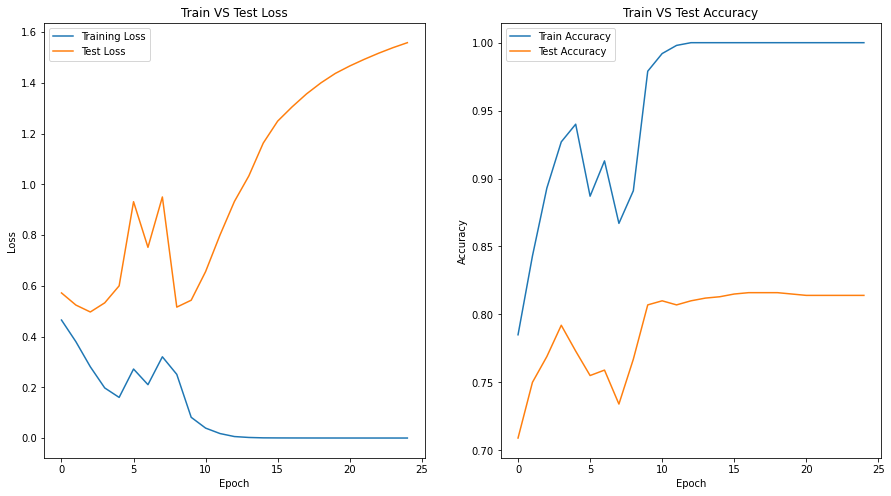

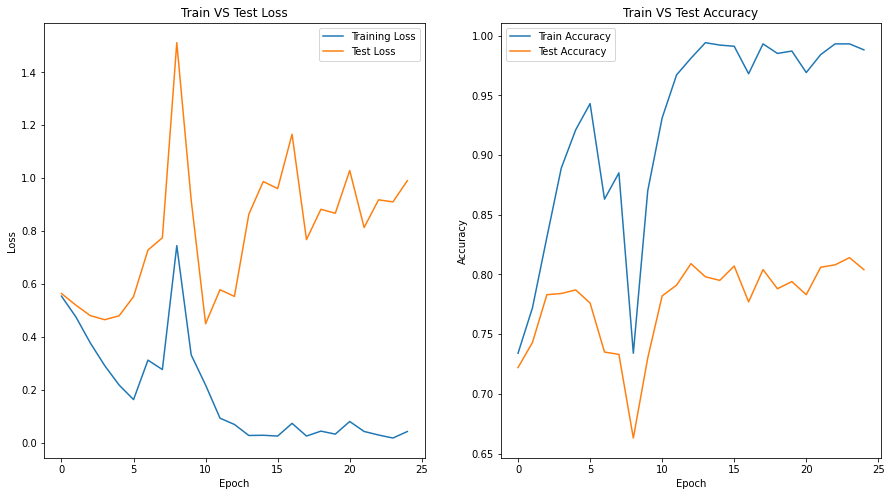

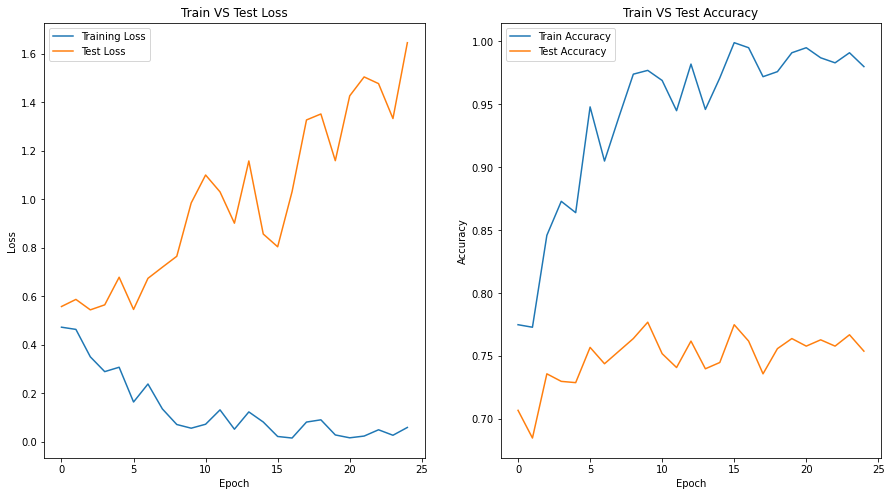

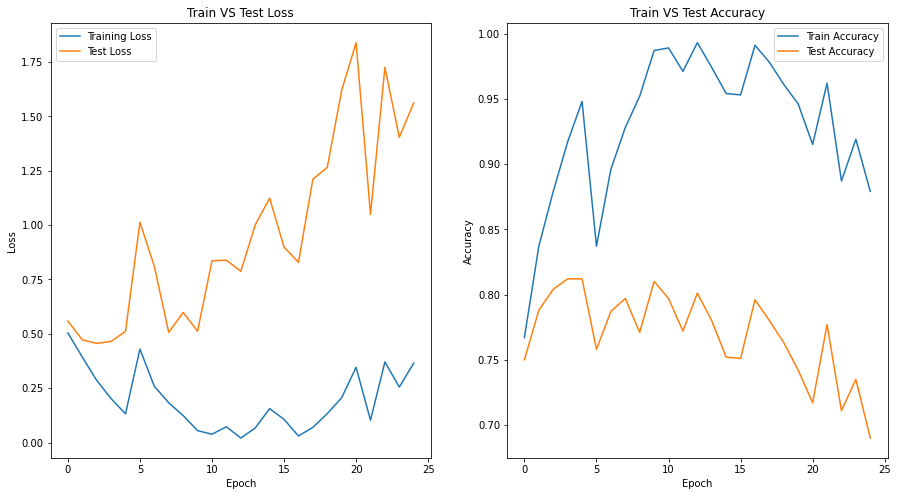

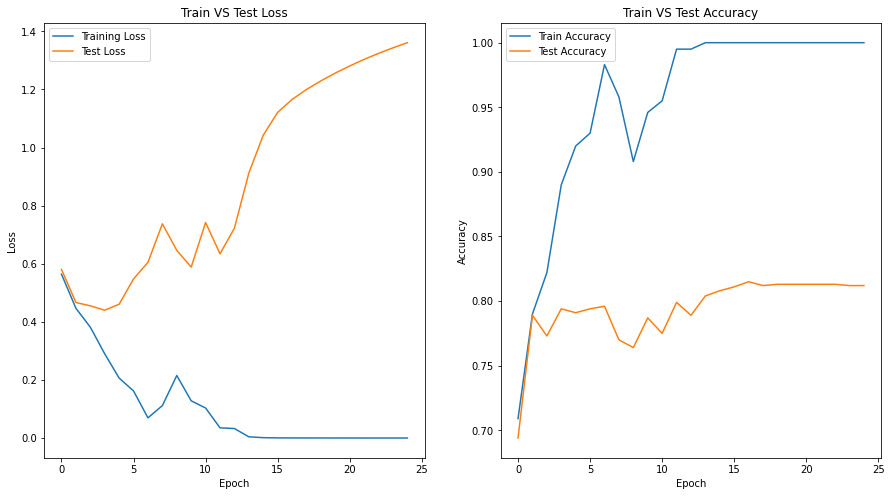

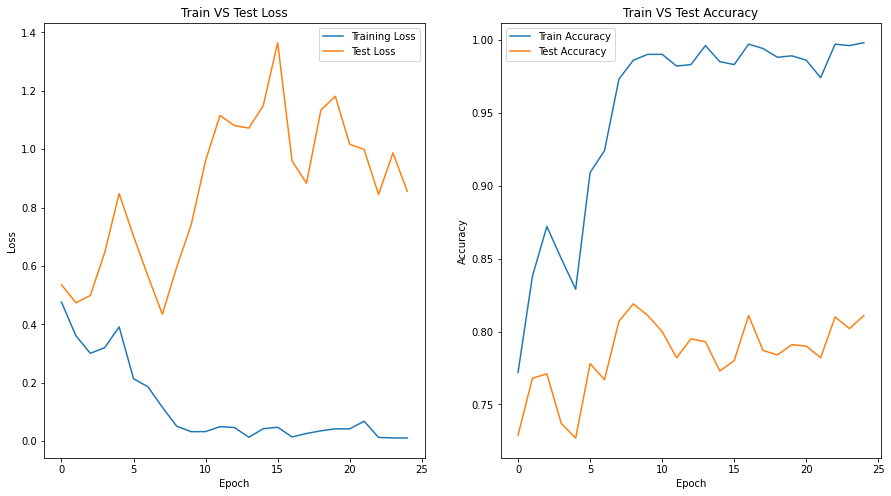

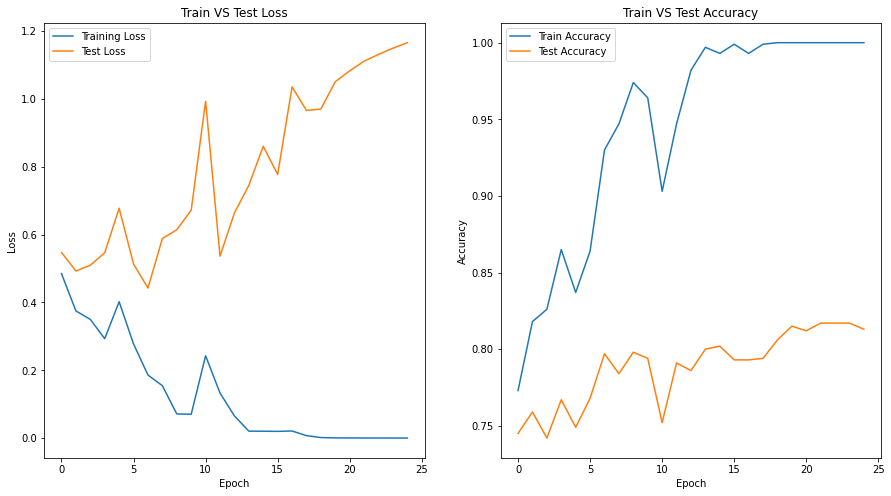

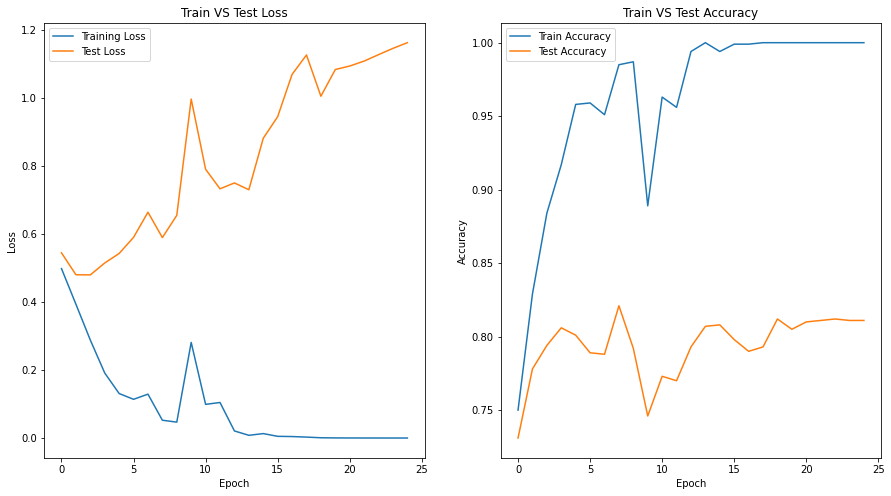

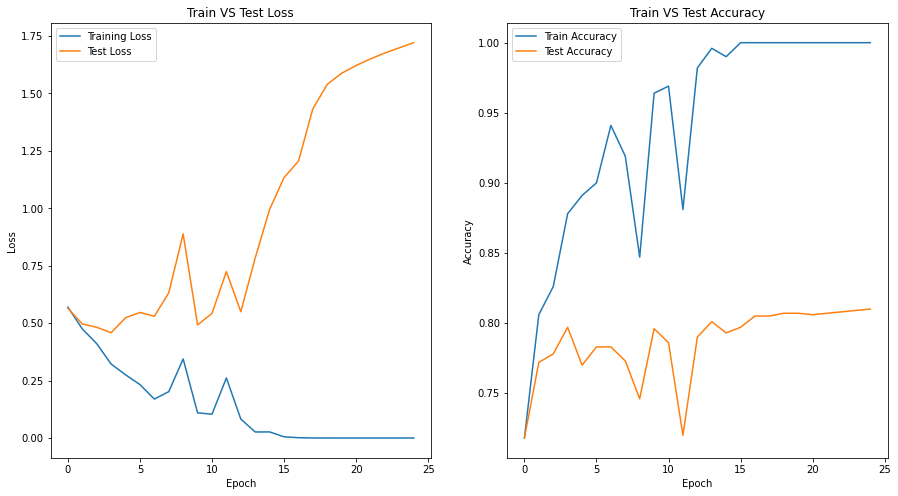

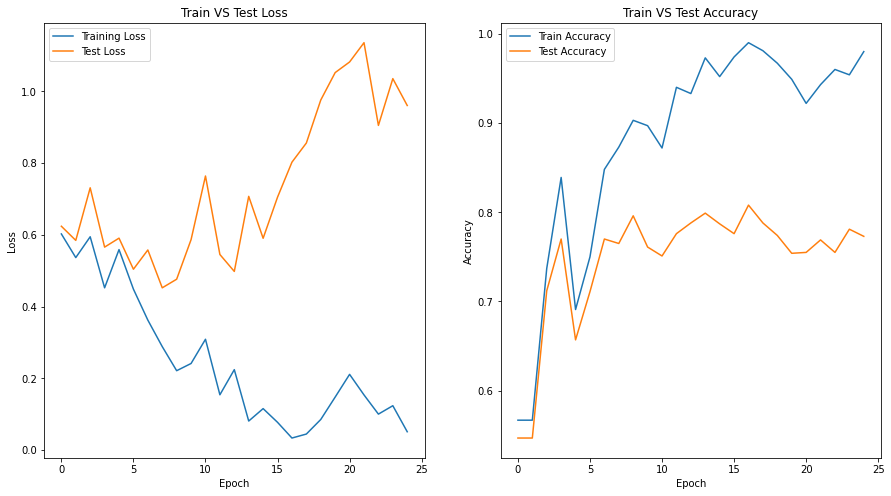

In [12]:
# calculate the standard deviation:
train_errors=[]
test_errors=[]
for num in range(10):
    N_PAIRS = 1000
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N_PAIRS)
    tran_train_input=train_input.view(-1,2*14*14)
    tran_test_input=test_input.view(-1,2*14*14)
    my_model = MLP_Net()
    # train the model
    my_model.trainer(tran_train_input, train_target,tran_test_input, test_target)
    # output the train error and test error
    print("Train error : %.1f%% \nTest error : %.1f%%" %
      (my_model.compute_error(tran_train_input, train_target),
       my_model.compute_error(tran_test_input, test_target)))
    print("The total number of the parameters is: %d" % (sum(p.numel() for p in my_model.parameters())))
    train_errors.append(my_model.compute_error(tran_train_input, train_target))
    test_errors.append(my_model.compute_error(tran_test_input, test_target))

In [13]:
print('The standard deviation of train error:',np.std(train_errors))
print('The standard deviation of test error:',np.std(test_errors))
print('The mean of train error:',np.mean(train_errors))
print('The mean of test error:',np.mean(test_errors))

The standard deviation of train error: 0.0353927939869075
The standard deviation of test error: 0.0382695703984562
The mean of train error: 0.01749999523162842
The mean of test error: 0.21079999804496766


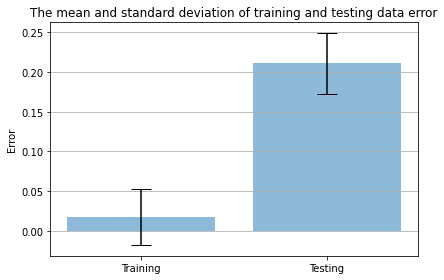

In [14]:
#plot the standard 
# Define labels, positions, bar heights and error bar heights
labels = ['Training', 'Testing']
x_pos = np.arange(len(labels))
means = [np.mean(train_errors), np.mean(test_errors)]
stds = [np.std(train_errors), np.std(test_errors)]
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, means,
       yerr=stds,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('Error')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('The mean and standard deviation of training and testing data error')
ax.yaxis.grid(True)

# show the plot
plt.tight_layout()
plt.show()